In [1]:
push!(LOAD_PATH, "../lib/")

3-element Array{String,1}:
 "/usr/local/share/julia/site/v0.6"
 "/usr/share/julia/site/v0.6"      
 "../lib/"                         

In [2]:
using NaCsData

In [3]:
using LsqFit
using PyPlot
using Dierckx

In [4]:
power_calib = sortrows(readcsv("tweezer_power.csv", Float64, skipstart=1));

In [5]:
power_spl = Spline1D(power_calib[:, 1], power_calib[:, 2]);

In [6]:
dc_05 = NaCsData.calc_survival("dc_0.05/data_20160223_201552.csv");
dc_12 = NaCsData.calc_survival(["dc_0.12/data_20160223_125309.csv",
                                "dc_0.12/data_20160223_132816.csv",
                                "dc_0.12/data_20160223_154907.csv"]);
dc_5 = NaCsData.calc_survival("dc_0.5/data_20160223_173259.csv");

In [7]:
orig_depth = power_spl(0.12)
depth1 = power_spl(0.05) / orig_depth
depth3 = power_spl(0.5) / orig_depth
fitx1 = [linspace(depth1, depth1, length(dc_05[1])) power_spl(dc_05[1]) ./ orig_depth]
fitx2 = [linspace(1, 1, length(dc_12[1])) power_spl(dc_12[1]) ./ orig_depth]
fitx3 = [linspace(depth3, depth3, length(dc_5[1])) power_spl(dc_5[1]) ./ orig_depth]
fitx = [fitx1; fitx2; fitx3];
fity = [dc_05[2][:, 2]; dc_12[2][:, 2]; dc_5[2][:, 2]];
fitw = [dc_05[3][:, 2]; dc_12[3][:, 2]; dc_5[3][:, 2]];

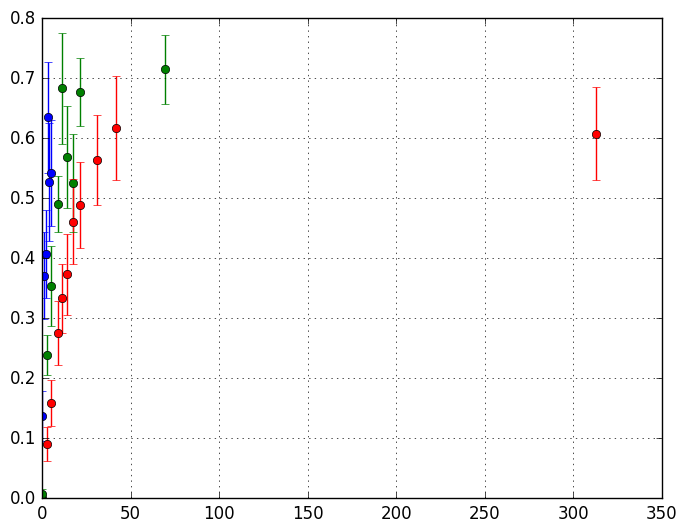

In [8]:
errorbar(power_spl(dc_05[1]), dc_05[2][:, 2], dc_05[3][:, 2], fmt="bo")
errorbar(power_spl(dc_12[1]), dc_12[2][:, 2], dc_12[3][:, 2], fmt="go")
errorbar(power_spl(dc_5[1]), dc_5[2][:, 2], dc_5[3][:, 2], fmt="ro")
grid()

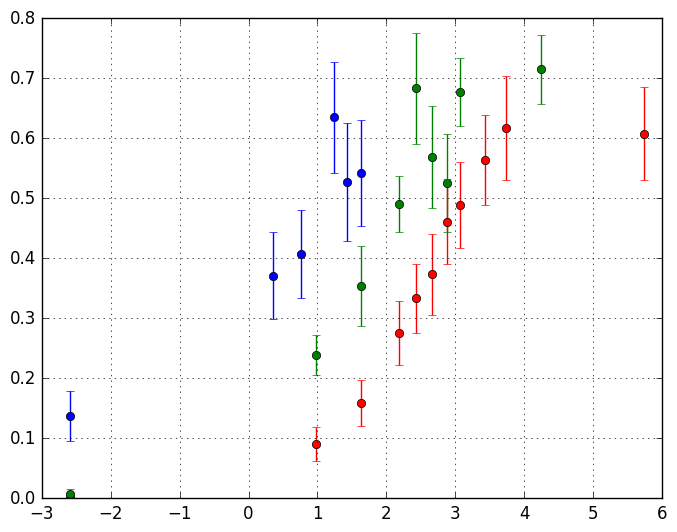

In [9]:
errorbar(log(power_spl(dc_05[1])), dc_05[2][:, 2], dc_05[3][:, 2], fmt="bo")
errorbar(log(power_spl(dc_12[1])), dc_12[2][:, 2], dc_12[3][:, 2], fmt="go")
errorbar(log(power_spl(dc_5[1])), dc_5[2][:, 2], dc_5[3][:, 2], fmt="ro")
grid()

See [here](Model.ipynb) for fitting model

In [10]:
cdf_harmonic(x) = 1 - (1 + x + x.^2 ./ 2) .* exp(-x)

cdf_harmonic (generic function with 1 method)

In [11]:
function model(x, p)
    # x[:, 1]: raising ratio (compare to initial trap depth)
    # x[:, 2]: lowering ratio (compare to initial trap depth)
    # y = p[1] * CDF(p[2] * ɛ)
    α = x[:, 1]
    γ = x[:, 2]
    ɛ = 2 .* √(α) .* γ ./ (γ .+ α)
    p[1] * cdf_harmonic(ɛ ./ p[2])
end

model (generic function with 1 method)

In [12]:
fit = curve_fit(model, fitx, fity, 1 ./ (fitw + 0.01), [0.7, 0.05]);

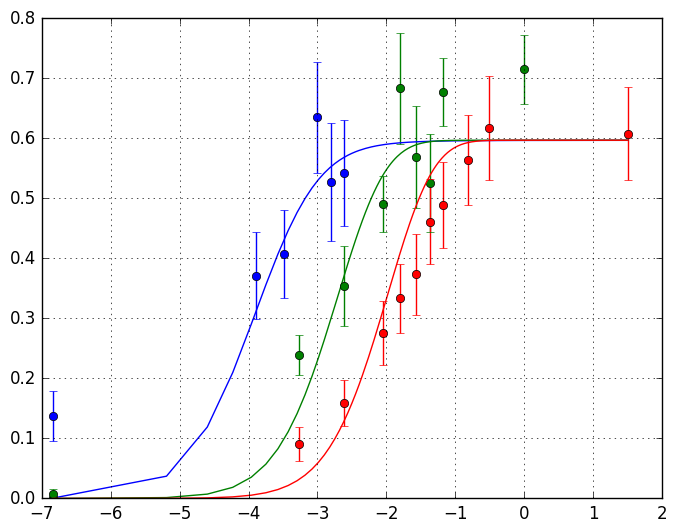

In [13]:
plotx = linspace(minimum(fitx[:, 2]), maximum(fitx[:, 2]), 1000)

plot(log(plotx), model([linspace(depth1, depth1, 1000) plotx], fit.param), "b")
errorbar(log(power_spl(dc_05[1]) / orig_depth), dc_05[2][:, 2], dc_05[3][:, 2], fmt="bo")

plot(log(plotx), model([linspace(1, 1, 1000) plotx], fit.param), "g")
errorbar(log(power_spl(dc_12[1]) / orig_depth), dc_12[2][:, 2], dc_12[3][:, 2], fmt="go")

plot(log(plotx), model([linspace(depth3, depth3, 1000) plotx], fit.param), "r")
errorbar(log(power_spl(dc_5[1]) / orig_depth), dc_5[2][:, 2], dc_5[3][:, 2], fmt="ro")
grid()

In [14]:
sigma = estimate_errors(fit, 0.95)

2-element Array{Float64,1}:
 0.049163  
 0.00630421

In [15]:
fit.param[2], sigma[2]

(0.04256540290743047,0.006304205457547146)